In [ ]:
!pip install optuna
!pip install sklearn
!pip install hylite
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 4.3 MB/s eta 0:00:0

In [ ]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 53.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [ ]:
import optuna
import numpy as np
from sklearn.model_selection import train_test_split
from hylite import io

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
"""
 Path to input files:
 dat - data (can be a multispectral or hyperspectral image with 'n' number of bands)
 target - variable to be predicted
"""

# For e.g. here we load a hyperspectral image (hydat) and a target abundance (abund).
# The target can be replaced with any other variable or parameter


hydat = io.load('/content/drive/My Drive/hsi_pansharp_data/prisma_PS_5.hdr')
abund = io.load('/content/drive/My Drive/hsi_pansharp_data/hymap_am.hdr')


print(hydat.data.shape)
print(abund.data.shape)

(533, 464, 230)
(533, 464, 3)


In [ ]:
hydat.data[ hydat.data <= 0. ] = np.nan
hydat.fill_holes()
hydat.data = hydat.data.astype(np.float32)
hydat.data=np.round(hydat.data, 4)

In [ ]:
abund.data[ abund.data <= 0. ] = np.nan
abund.fill_holes()
abund.data = abund.data.astype(np.float32)
abund.data=np.round(abund.data, 4)

In [ ]:
"""
Reshape the original data to create an input-ready data for the optimizer
"""


X_data = hydat.data
C_data = abund.data

print(X_data.shape, C_data.shape)

def reshape(arr):
  num_rows, num_cols, num_bands = arr.shape
  reshp_arr = np.reshape(arr, (num_rows * num_cols, num_bands))
  return reshp_arr

X = reshape(X_data)
C = reshape(C_data)

print(X.shape, C.shape)

(533, 464, 230) (533, 464, 3)
(247312, 230) (247312, 3)


In [ ]:
"""
Load reference abundance class
0- Calcite, 1- Dolomite, 2- Country Rock
"""
cls = 2

C_ref = C[:,cls]
C_ref.shape

(247312,)

In [ ]:
import numpy as np
import joblib
import optuna
import shap
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from skimage.metrics import structural_similarity as ssim
from scipy.stats import wasserstein_distance

# Define global variables to store the top indices and associated bands
global_top_indices = None
global_top_bands = None
global_feature_mappings = None

# Define the number of spectral bands required for trials
nb = 36

def objective(trial):
    global global_top_indices, global_top_bands, global_feature_mappings  # Declare the global variables

    num_bands = X.shape[1]  # Number of hyperspectral bands

    # Suggest band indices for each spectral band
    bands = [trial.suggest_int(f"B{i+1}", 0, num_bands-1) for i in range(nb)]

    # Ensure that selected band indices are distinct for specific conditions
    pairs = [(0, 1), (4, 5), (9, 10), (14, 15), (20, 21), (22, 23), (24, 25), (30, 31)]
    for i, j in pairs:
        if bands[i] == bands[j]:
            return -float('inf')

    # Calculate band indices
    index1 = X[:, bands[0]] - X[:, bands[1]]
    index2 = X[:, bands[2]] + X[:, bands[3]]
    index3 = (X[:, bands[4]] - X[:, bands[5]]) / (X[:, bands[4]] + X[:, bands[5]] + 1e-11)
    index4 = X[:, bands[6]] / (X[:, bands[7]] + 1e-11)

    index5 = X[:, bands[8]] / (X[:, bands[9]] - X[:, bands[10]] + 1e-11)
    index6 = X[:, bands[11]] / (X[:, bands[12]] + X[:, bands[13]] + 1e-11)
    index7 = (X[:, bands[14]] - X[:, bands[15]]) / (X[:, bands[16]] + 1e-11)
    index8 = (X[:, bands[17]] + X[:, bands[18]]) / (X[:, bands[19]] + 1e-11)

    index9 = (X[:, bands[20]] - X[:, bands[21]]) / (X[:, bands[22]] - X[:, bands[23]] + 1e-11)
    index10 = (X[:, bands[24]] - X[:, bands[25]]) / (X[:, bands[26]] + X[:, bands[27]] + 1e-11)
    index11 = (X[:, bands[28]] + X[:, bands[29]]) / (X[:, bands[30]] - X[:, bands[31]] + 1e-11 )
    index12 = (X[:, bands[32]] + X[:, bands[33]]) / (X[:, bands[34]] + X[:, bands[35]] + 1e-11 )

    # Stack all indices as features for regression
    features = np.stack((index1, index2, index3, index4, index5, index6, index7, index8, index9, index10, index11, index12), axis=1)

    # Split samples into training and testing sets
    X_train, X_test, C_train, C_test = train_test_split(features, C_ref, test_size=0.4, random_state=42)

    # Replace NaN with 0

    X_train[np.isnan(X_train)] = 0
    X_test[np.isnan(X_test)] = 0
    C_train[np.isnan(C_train)] = 0
    C_test[np.isnan(C_test)] = 0


    # Train a regression model

    model = linear_model.Ridge(alpha = 0.5)
    model.fit(X_train, C_train)


    # model = linear_model.LinearRegression()
    # model.fit(X_train, C_train)


    # Calculate SHAP values
    explainer = shap.LinearExplainer(model, X_train)
    shap_values = explainer.shap_values(X_train)

    # Compute the mean absolute SHAP value for each index
    mean_shap_values = np.abs(shap_values).mean(axis=0)

    # Select the top 'n' indices with the highest SHAP values
    top_indices = np.argsort(mean_shap_values)[-2:] # Determine 'n'

    # Save the top indices and associated bands to global variables
    global_top_indices = top_indices.tolist()

    # Define the mapping from feature index to band indices
    feature_mappings = {
        0: (bands[0], bands[1]),
        1: (bands[2], bands[3]),
        2: (bands[4], bands[5]),
        3: (bands[6], bands[7]),
        4: (bands[8], bands[9], bands[10]),
        5: (bands[11], bands[12], bands[13]),
        6: (bands[14], bands[15], bands[16]),
        7: (bands[17], bands[18], bands[19]),
        8: (bands[20], bands[21], bands[22], bands[23]),
        9: (bands[24], bands[25], bands[26], bands[27]),
        10: (bands[28], bands[29], bands[30], bands[31]),
        11: (bands[32], bands[33], bands[34], bands[35])
    }

    global_feature_mappings = {i: feature_mappings[i] for i in top_indices}

    # Create a new feature set with only the top indices
    X_train_top = X_train[:, top_indices]
    X_test_top = X_test[:, top_indices]

    # Re-train the regression model with the top features
    model.fit(X_train_top, C_train)

    # Predict using the re-trained model
    C_pred = model.predict(X_test_top)

    # Compute R-squared score as the objective value
    r_squared = r2_score(C_test, C_pred)
    rmse = mean_squared_error(C_test, C_pred, squared=False)
    #mae = mean_absolute_error(C_test, C_pred)
    #emd = wasserstein_distance(C_test, C_pred)

    data_range = C_test.max() - C_test.min()
    ssim_index, ssim_map = ssim(C_test, C_pred, data_range=data_range, full=True)


    # Save the model if it has the best score
    best_score = trial.study.user_attrs.get("best_score", -np.inf)
    if best_score < r_squared:
        trial.study.user_attrs["best_score"] = r_squared
        joblib.dump(model, "best_model.pkl")

    # Return the R-squared score
    return r_squared, rmse, ssim_index
    #return r_squared

In [ ]:
import optuna
from optuna.trial import FrozenTrial

class MOEarlyStopping:
    def __init__(self, patience: int, min_delta: float = 0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_values = None
        self.counter = 0

    def __call__(self, study: optuna.study.Study, trial: FrozenTrial):
        # Skip failed trials (i.e., if trial.values is None)
        if trial.values is None:
            return

        # Initialize best values if this is the first call
        if self.best_values is None:
            self.best_values = trial.values
            return

        # Check if there has been improvement
        improved = False
        for i, direction in enumerate(study.directions):
            if direction == optuna.study.StudyDirection.MAXIMIZE:
                if trial.values[i] > self.best_values[i] + self.min_delta:
                    improved = True
            else:  # MINIMIZE
                if trial.values[i] < self.best_values[i] - self.min_delta:
                    improved = True

        # Update best values and reset counter if improved
        if improved:
            self.best_values = trial.values
            self.counter = 0
        else:
            self.counter += 1

        # Stop if no improvement for `patience` trials
        if self.counter >= self.patience:
            print("Early stopping triggered.")
            study.stop()

In [ ]:
# Instantiate the early stopping callback
early_stopping = MOEarlyStopping(patience=500, min_delta=1e-4)

# Create the study and run the optimization with the custom early stopping callback
study = optuna.create_study(directions=["maximize", "minimize", "maximize"], sampler=optuna.samplers.NSGAIIISampler())
#study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())

#study.optimize(objective, n_trials=1000, n_jobs = 4)
study.optimize(objective, n_trials=2500, callbacks=[early_stopping], n_jobs = 4)

[I 2024-09-17 21:57:50,282] A new study created in memory with name: no-name-fab002c6-b1f7-4695-ae1e-61915df73c37
[I 2024-09-17 21:57:51,116] Trial 0 finished with values: [0.24822163581848145, 0.2564997375011444, 0.3454120412205476] and parameters: {'B1': 35, 'B2': 94, 'B3': 20, 'B4': 159, 'B5': 221, 'B6': 175, 'B7': 140, 'B8': 164, 'B9': 134, 'B10': 139, 'B11': 217, 'B12': 41, 'B13': 53, 'B14': 20, 'B15': 137, 'B16': 163, 'B17': 4, 'B18': 42, 'B19': 161, 'B20': 92, 'B21': 77, 'B22': 3, 'B23': 150, 'B24': 50, 'B25': 120, 'B26': 42, 'B27': 77, 'B28': 205, 'B29': 48, 'B30': 20, 'B31': 178, 'B32': 166, 'B33': 67, 'B34': 13, 'B35': 221, 'B36': 75}.
[I 2024-09-17 21:57:51,231] Trial 2 finished with values: [0.07831424474716187, 0.2840099036693573, 0.165432749604043] and parameters: {'B1': 71, 'B2': 54, 'B3': 188, 'B4': 119, 'B5': 89, 'B6': 208, 'B7': 149, 'B8': 71, 'B9': 184, 'B10': 195, 'B11': 111, 'B12': 182, 'B13': 89, 'B14': 177, 'B15': 34, 'B16': 139, 'B17': 216, 'B18': 50, 'B19': 75,

In [ ]:
for trial in study.best_trials:
  print(trial.number, trial.values[0],trial.values[1],trial.values[2])

# best_trial = study.best_trial
# print(best_trial.number, best_trial.values)

1206 0.47046083211898804 0.21527375280857086 0.5622223847673385
1267 0.47046083211898804 0.21527375280857086 0.5622223847673385
1318 0.47046083211898804 0.21527375280857086 0.5622223847673385
1375 0.47046083211898804 0.21527375280857086 0.5622223847673385
1391 0.47046083211898804 0.21527375280857086 0.5622223847673385
1444 0.47046083211898804 0.21527375280857086 0.5622223847673385
1479 0.47046083211898804 0.21527375280857086 0.5622223847673385
1512 0.47046083211898804 0.21527375280857086 0.5622223847673385
1520 0.47031962871551514 0.2153024524450302 0.5623894552139796
1526 0.47046083211898804 0.21527375280857086 0.5622223847673385
1528 0.47046083211898804 0.21527375280857086 0.5622223847673385
1536 0.47046083211898804 0.21527375280857086 0.5622223847673385
1539 0.47046083211898804 0.21527375280857086 0.5622223847673385
1540 0.47046083211898804 0.21527375280857086 0.5622223847673385
1541 0.47046083211898804 0.21527375280857086 0.5622223847673385
1547 0.47046083211898804 0.21527375280857

In [ ]:
# Access and print global variables
print("Top indices and associated bands:")
for i, idx in enumerate(global_top_indices):
    bands_for_feature = global_feature_mappings[idx]
    print(f"Top index {i+1}: index{idx + 1}")
    print(f"Associated bands: {', '.join(map(str, bands_for_feature))}")

Top indices and associated bands:
Top index 1: index9
Associated bands: 123, 81, 223, 125
Top index 2: index12
Associated bands: 106, 204, 52, 187


In [ ]:
# Get wavelengths from hyperspectral data
wav = hydat.get_wavelengths()

In [ ]:
# Print selected wavelength numbers
WLnum = []

for values in global_feature_mappings.values():
    WLnum.extend(values)

print("All selected wavelength numbers:", WLnum)

All selected wavelength numbers: [123, 81, 223, 125, 106, 204, 52, 187]


In [ ]:
# Print selected wavelengths
WL = []
for i in WLnum:
  WL.append(wav[i])

print("All selected wavelengths:",WL)

All selected wavelengths: [1616.833618, 1163.676025, 2456.585693, 1637.091919, 1438.465942, 2320.895508, 870.742554, 2191.100342]


In [ ]:
# Initialize an empty list to store the calculated indices
findex_list = []

# Iterate over the top indices and calculate the corresponding features
for idx in global_top_indices:
    bands = global_feature_mappings[idx]

    if len(bands) == 2:
        if idx == 0:
            feature = X[:, bands[0]] - X[:, bands[1]]
        elif idx == 1:
            feature = X[:, bands[0]] + X[:, bands[1]]
        elif idx == 2:
            feature = (X[:, bands[0]] - X[:, bands[1]]) / (X[:, bands[0]] + X[:, bands[1]] + 1e-11)
        else:
            feature = (X[:, bands[0]]) / (X[:, bands[1]] + 1e-11)

    elif len(bands) == 3:
        if idx == 4:
            feature = (X[:, bands[0]]) / (X[:, bands[1]] - X[:, bands[2]] + 1e-11)
        elif idx == 5:
            feature = (X[:, bands[0]]) / (X[:, bands[1]] + X[:, bands[2]] + 1e-11)
        elif idx == 6:
            feature = (X[:, bands[0]] - X[:, bands[1]]) / (X[:, bands[2]] + 1e-11)
        else:
            feature = (X[:, bands[0]] + X[:, bands[1]]) / (X[:, bands[2]] + 1e-11)


    elif len(bands) == 4:
        if idx == 8:
            feature = (X[:, bands[0]] - X[:, bands[1]]) / (X[:, bands[2]] - X[:, bands[3]] + 1e-11)
        elif idx == 9:
            feature = (X[:, bands[0]] - X[:, bands[1]]) / (X[:, bands[2]] + X[:, bands[3]] + 1e-11)
        elif idx == 10:
            feature = (X[:, bands[0]] + X[:, bands[1]]) / (X[:, bands[2]] - X[:, bands[3]] + 1e-11)
        else:
            feature = (X[:, bands[0]] + X[:, bands[1]]) / (X[:, bands[2]] + X[:, bands[3]] + 1e-11)


    # Append the feature to the findex list
    findex_list.append(feature)

# Stack the list into a single numpy array
findex = np.stack(findex_list, axis=1)

findex[np.isnan(findex)] = 0

# Predict using the loaded best model
best_model = joblib.load("best_model.pkl")  # Load the best model from the file
predictions = best_model.predict(findex)
predictions = np.clip(predictions, 0, 1)
print("Predictions on new data:", predictions)

Predictions on new data: [0.6838851  0.6757333  0.6789744  ... 0.74709415 0.7414093  0.7391734 ]


In [ ]:
predicted = predictions.reshape(abund.data[:,:,cls].shape)
predicted.shape

(533, 464)

In [ ]:
# Extract relevant slices
ref = abund.data[:, :, cls]
pred = predicted
#nnls = unmix_abund.data[:, :, cls]

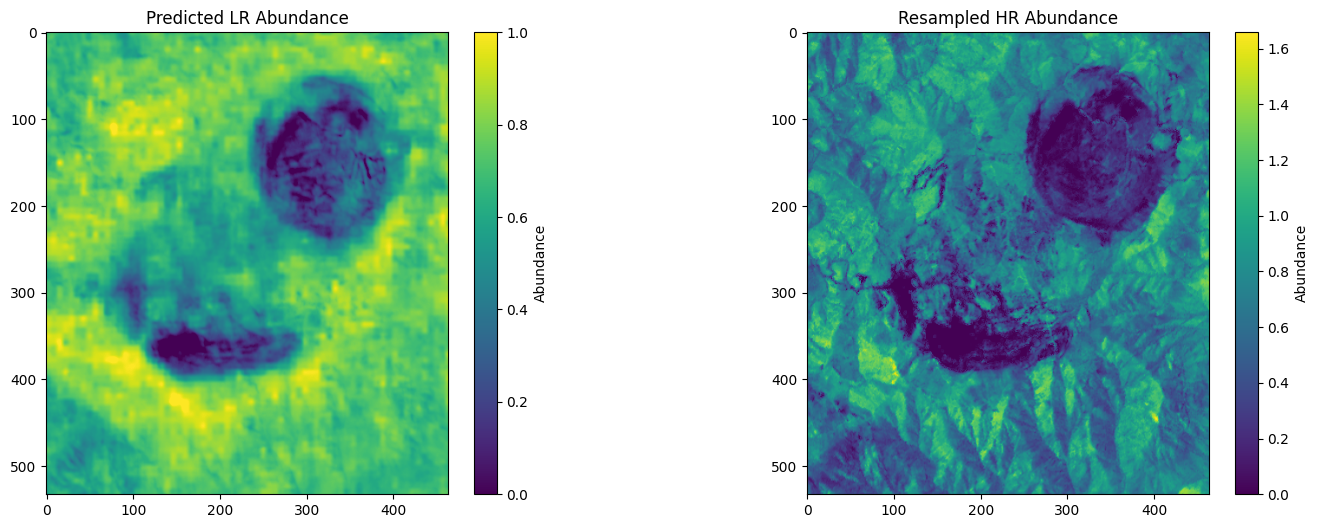

In [ ]:

# Print the predicted abundance image for verification

import matplotlib.pyplot as plt

# Create a figure and set size
#fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
# HR-predicted abundance image
im1 = axs[0].imshow(predicted, cmap='viridis')
axs[0].set_title("Predicted LR Abundance")
axs[0].axis('on')
# axs[0].set_xlabel('X-axis Label')  # Optional: Add axis labels if needed
# axs[0].set_ylabel('Y-axis Label')

# Add colorbar for the first subplot
cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical', fraction=0.05, pad=0.04)
cbar1.set_label('Abundance')

# LR-reference abundance image
im2 = axs[1].imshow(ref, cmap='viridis')
axs[1].set_title("Resampled HR Abundance")
axs[1].axis('on')
# axs[1].set_xlabel('X-axis Label')
# axs[1].set_ylabel('Y-axis Label')

# Add colorbar for the second subplot
cbar2 = fig.colorbar(im2, ax=axs[1], orientation='vertical', fraction=0.05, pad=0.04)
cbar2.set_label('Abundance')

# # LR-reference abundance image
# im3 = axs[2].imshow(nnls, cmap='viridis')
# axs[2].set_title("NNLS LR Abundance")
# axs[2].axis('on')
# # axs[2].set_xlabel('X-axis Label')
# # axs[2].set_ylabel('Y-axis Label')

# # Add colorbar for the second subplot
# cbar3 = fig.colorbar(im3, ax=axs[2], orientation='vertical', fraction=0.05, pad=0.04)
# cbar3.set_label('Abundance')

# Display the plot
plt.show()

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float
import numpy as np

# Convert to float
pred_float = img_as_float(pred)
ref_float = img_as_float(ref)
# nnls_float = img_as_float(nnls)

# Specify data_range (max abundance of reference)
data_range = np.max(ref_float)

# Create a mask for non-zero values
mask = ref_float > 0

# Apply mask to images
masked_ref = np.where(mask, ref_float, 0)
masked_pred = np.where(mask, pred_float, 0)
# masked_nnls = np.where(mask, nnls_float, 0)

# Calculate SSIM only for masked (non-zero) values
ssim_pred, _ = ssim(masked_pred, masked_ref, data_range=data_range, full=True)
# ssim_nnls, _ = ssim(masked_nnls, masked_ref, data_range=data_range, full=True)

print(f"Structural Similarity Index (SSIM) for Predicted: {ssim_pred}")
# print(f"Structural Similarity Index (SSIM) for NNLS: {ssim_nnls}")

# Store SSIM values in a dictionary
# ssims = {'ssimnnls': ssim_nnls, 'ssimpred': ssim_pred}

Structural Similarity Index (SSIM) for Predicted: 0.2739537640039217


In [ ]:
def mean_without_zeros(array):
  """
  Calculates the mean of a numpy array, excluding zero values.
  """

  # Filter out zero values
  non_zero_values = array[array != 0]

  # Handle the case where all values are zero
  if len(non_zero_values) == 0:
    return 0  # Or handle it differently as needed

  # Calculate the mean of non-zero values
  mean = np.mean(non_zero_values)
  return mean

ref_mean = mean_without_zeros(ref_float)

pred_mean = mean_without_zeros(pred_float)

nnls_mean = mean_without_zeros(nnls_float)

print(ref_mean, pred_mean, nnls_mean )

abunds = {'reference, predicted, nnls': [ref_mean, pred_mean, nnls_mean]}

0.15420474 0.13055283 0.25554578651685395


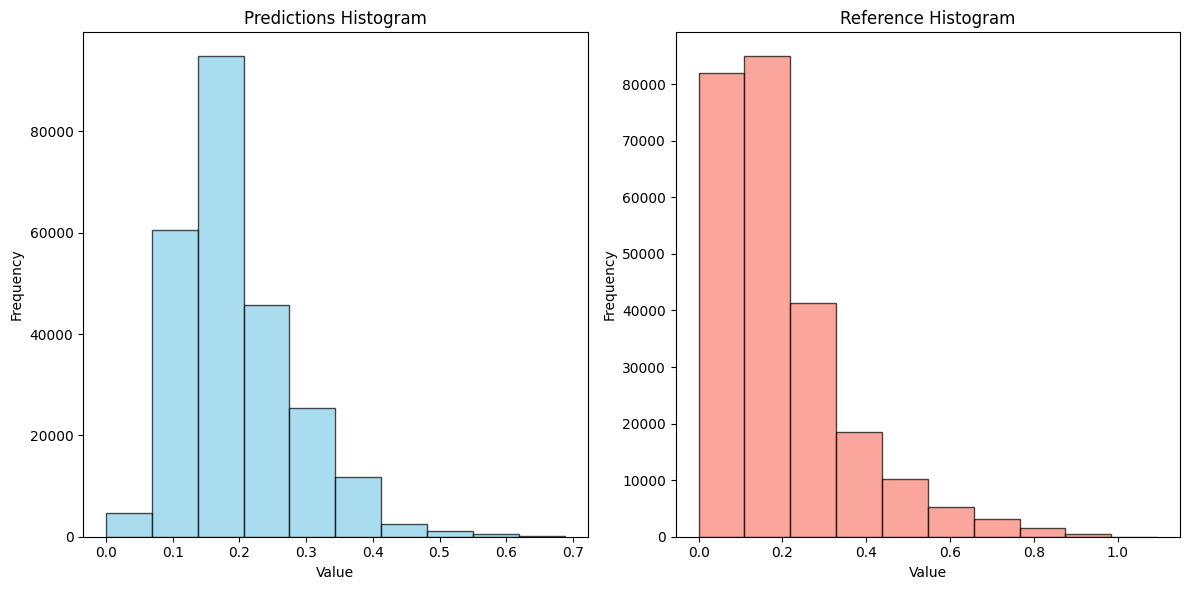

In [ ]:
# Create a figure with two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first histogram
ax1.hist(predictions, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Predictions Histogram')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')

# Plot the second histogram
ax2.hist(C_ref, bins=10, color='salmon', edgecolor='black', alpha=0.7)
ax2.set_title('Reference Histogram')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
hist, _ = np.histogram(C_ref, bins=10)
print(hist)

[4353  202  117  118  117   91   69   58   37    4]


**Save Model and Results**